In [3]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import matplotlib.animation as animation
import matplotlib
from hilbertcurve.hilbertcurve import HilbertCurve

from mypymorton import interleave3
from pymorton import deinterleave2
from pymongo import MongoClient

from sklearn.decomposition import PCA

from ugtm import eGTM, eGTC, eGTR


matplotlib.rcParams['animation.embed_limit'] = 400
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Palatino'], 'size': 16})
rc('text', usetex=True)

In [4]:
neuron_pos = pd.read_csv("../data/neuron_positions.csv")
neuron_pos.set_index("id")
neuron_pos.head(10)

level = 1

coms_df = pd.read_csv(f"../data/coms_df.csv")
# coms = coms_df[f"level_{level}"]
neuron_pos.x -= np.mean(neuron_pos.x)
neuron_pos.y -= np.mean(neuron_pos.y)
neuron_pos.z -= np.mean(neuron_pos.z)
if level > 0:
    level_1_pos = neuron_pos[["x", "y", "z"]].groupby(neuron_pos["id"] // 10).mean()
    pos_with_coms = level_1_pos.merge(coms_df, left_on="id", right_on=f"id")
    positions = pos_with_coms.groupby(f"level_{level}").mean()[["x", "y", "z"]]
    # rename index to id
    print(positions)
    positions.index = positions.index.rename("index")
    positions["id"] = positions.index
else:
    positions = neuron_pos[["x", "y", "z"]]

positions
# max(max(positions["x"]), max(positions["y"]), max(positions["z"]))

# unit_brain = positions.copy()
# scale = max(max(positions["x"]), max(positions["y"]), max(positions["z"]))

# unit_brain["x"] = unit_brain["x"] / scale
# unit_brain["y"] = unit_brain["y"] / scale
# unit_brain["z"] = unit_brain["z"] / scale

# unit_brain["x"] -= np.mean(unit_brain["x"])
# unit_brain["y"] -= np.mean(unit_brain["y"])
# unit_brain["z"] -= np.mean(unit_brain["z"])

                x          y         z
level_1                               
0        1.698874  70.343688  0.601685
1        1.904782  70.404715 -1.400644
2        3.671188  69.309390  0.804720
3        2.295784  69.239066  3.645945
4       -0.789082  70.307442  4.335904
...           ...        ...       ...
4995    -2.167020 -72.518749 -6.025323
4996     1.786097 -72.547960 -5.553128
4997     2.307604 -71.655299 -1.399803
4998    -0.784268 -71.645010 -0.765602
4999     0.431353 -71.614601 -2.668810

[5000 rows x 3 columns]


,x,y,z,id
index,,,,
0,1.698874,70.343688,0.601685,0
1,1.904782,70.404715,-1.400644,1
2,3.671188,69.309390,0.804720,2
3,2.295784,69.239066,3.645945,3
4,-0.789082,70.307442,4.335904,4
...,...,...,...,...
4995,-2.167020,-72.518749,-6.025323,4995
4996,1.786097,-72.547960,-5.553128,4996
4997,2.307604,-71.655299,-1.399803,4997


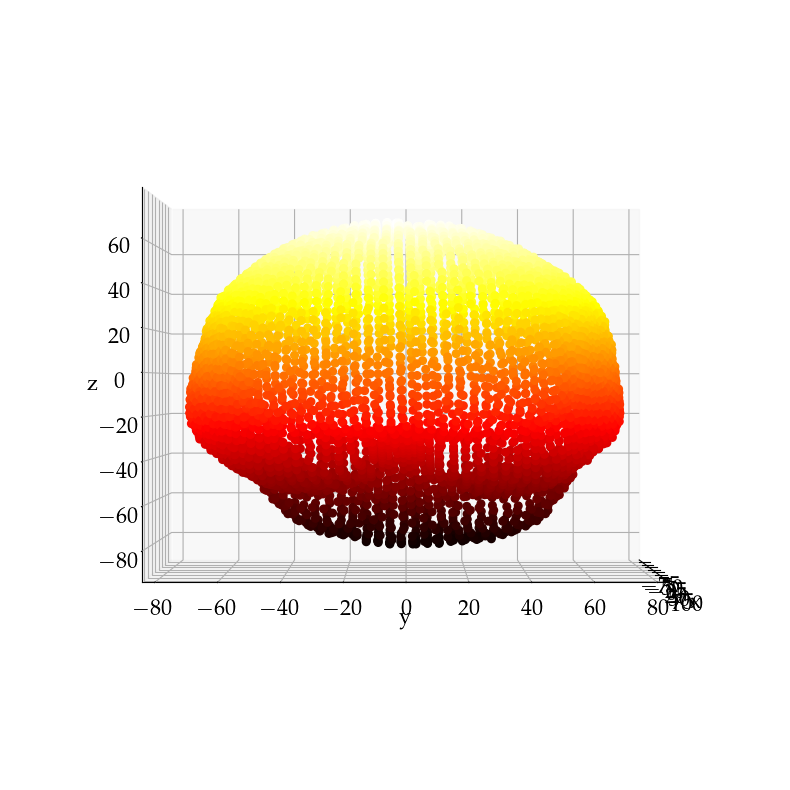

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(0, 0)
ax.scatter(positions["x"], positions["y"], positions["z"], c=positions["z"], cmap="hot", s=max(level * 30, 1), alpha=1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [6]:
x, y, z = positions["x"] / 1000, positions["y"]/ 1000, positions["z"]/ 1000
longitude = np.arctan2(y, x)
latitude = np.arctan2(z, np.sqrt(x**2 + y**2))
radius = np.sqrt(x**2 + y**2 + z**2)

# Print the first five points in spherical coordinates
# print("Longitude:", longitude[:5])
# print("Latitude:", latitude[:5])
# print("Radius:", radius[:5])




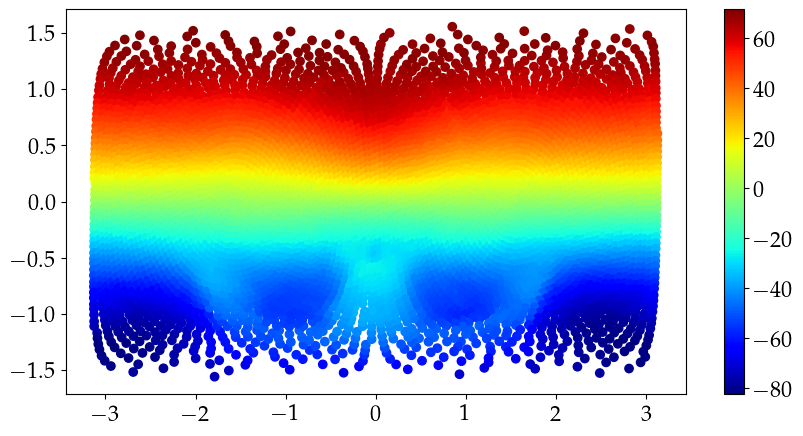

In [7]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

cm = plt.cm.jet
im = ax.scatter(longitude, latitude, c=positions["z"], cmap=cm)
fig.colorbar(im, ax=ax)
plt.show()

In [8]:
# calculate distance between farthest points
p1 = positions.loc[0]
p2 = positions.loc[positions.shape[0] - 1]

b = np.linalg.norm(p1[['x', 'y', 'z']] - p2[['x', 'y', 'z']]) / 2


# a = (max(positions.x) -  min(positions.x)) / 2
a = (max(positions.z) - min(positions.z)) / 2
c = (max(positions.x) - min(positions.x)) / 2

print(a, b, (max(positions.y) -  min(positions.y)) / 2)

e = np.sqrt(1 - (a**2 / c**2))
f = 1 - np.sqrt(1 - e**2)
print(1 - a / c)
print(e, f)

77.11829541715 71.00080719191686 73.23187065945001
0.17301955867651497
0.5622306907919685 0.17301955867651508


In [9]:
def equirectangular_projection(lon, lat):
    """Convert longitude and latitude values to x and y coordinates using the equirectangular projection."""
    R = (a + c) / 2  # radius of the sphere
    lambda0 = 0  # central meridian
    phi0 = 10  # standard parallel
    phi1 = 30  # first standard parallel
    x = R * (lon - lambda0) * np.cos(phi1)
    y = R * (lat - phi0)
    return x, y

equirectangular_x, equirectangular_y = equirectangular_projection(longitude, latitude)

print(equirectangular_x.head())

index
0    20.322980
1    20.284850
2    19.944911
3    20.204735
4    20.787731
dtype: float64


In [10]:
def cassini_projection(lambda_, phi, radius):
    """Convert longitude and latitude values to x and y coordinates using the Cassini projection."""
    R = (a + c) / 2  # radius of the sphere
    lambda0 = 0  # central meridian
    phi0 = 0  # standard parallel

    B = np.cos(phi) * np.sin(lambda_ - lambda0)

    x = R * np.arcsin(B)
    y = R * np.arctan2(np.sin(phi), np.cos(phi) * np.cos(lambda_ - lambda0)) - phi0

    return x, y

cassini_x, cassini_y = cassini_projection(longitude, latitude, radius)


In [11]:
def conic_projection(longitude, latitude, radius):
    lambda0 = 0
    phi1 = np.radians(10)
    n = np.sin(phi1)
    G = np.cos(phi1) / n + phi1
    rho = G - latitude
    rho0 = G - phi1
    x = rho * np.sin(n*(longitude - lambda0))
    y = rho0 - rho * np.cos(n*(longitude - lambda0))
    return np.column_stack((x, y)).T

conic_x, conic_y = conic_projection(longitude, latitude, radius)

print(conic_x[:10])

[1.54895194 1.55364743 1.52002096 1.52853851 1.56910081 1.60214648
 1.62305385 1.61417049 1.55981038 1.51447993]


In [12]:
def conic_ellipsoid_projection(lambda_, phi, radius):
    lambda0 = 0
    phi0 = np.radians(5)
    phi1 = np.radians(10)
    phi2 = np.radians(15)

    m1 = np.cos(phi1) / (1 - e**2 * np.sin(phi)**2)**0.5
    m2 = np.cos(phi2) / (1 - e**2 * np.sin(phi)**2)**0.5

    M_func = lambda phi: a * ((1 - e**2/4) - 3*e**4/64 + 5*e**6/256) * phi \
        - (3*e**2/8 - 3*e**4/32 + 45*e**6/1024) * np.sin(2*phi) \
        + (15*e**4/256 - 45*e**6/1024) * np.sin(4*phi) \
        - (35*e**6/3072) * np.sin(6*phi)

    M = M_func(phi)
    M0 = M_func(phi0)
    M1 = M_func(phi1)
    M2 = M_func(phi2)

    print(M1, M2)

    n = a * (m1 - m2) / (M2 - M1)

    G = m1 / n + M1 / a
    rho = a * G - M
    rho0 = a * G - M0

    theta = n*(lambda_ - lambda0)

    x = rho * np.sin(theta)
    y = rho0 - rho * np.cos(theta)
    return np.column_stack((x, y)).T

conic_ellipsoid_x, conic_ellipsoid_y = conic_ellipsoid_projection(longitude, latitude, radius)

print(conic_ellipsoid_x[:10])

12.306025824203719 18.460148521377526
[119.04780055 119.55642425 116.85584871 117.32905009 120.34340725
 122.94294498 124.74197294 124.33741241 120.30371745 116.74266638]


In [13]:
def van_der_grinten(lambda_, phi, radius):
    lambda0 = 0
    xsgn = np.sign(lambda_ - lambda0)
    ysgn = np.sign(phi)
    R = (a + c) / 2

    theta = np.arcsin(np.abs(2 * phi / np.pi))
    A = 0.5 * np.abs(np.pi / (lambda_ - lambda0) - (lambda_ - lambda0) / np.pi)
    G = np.cos(theta) / (np.sin(theta) + np.cos(theta) - 1)
    P = G * (2 / np.sin(theta)-1)
    Q = A**2 + G


    x = xsgn * np.pi * R * (A * (G - P ** 2) + (A**2 * (G - P**2)**2 - (P**2 + A**2)*(G**2 - P**2))**0.5) / (P**2 + A**2)
    y = ysgn * np.pi * R * (P*Q - A*((A**2 + 1) * (P**2 + A**2) - Q**2)**0.5) / (P**2 + A**2)

    return np.column_stack((x, y)).T


van_der_grinten_x, van_der_grinten_y = van_der_grinten(longitude, latitude, radius)


In [14]:
def stereographic_projection(lambda_, phi, radius):
    """
    Stereographic projection of 3D coordinates onto a 2D plane.
    
    Parameters:
        coords (numpy.ndarray): A 3D array of coordinates to be projected.
        
    Returns:
        A 2D array of projected coordinates.
    """

    k0 = 1
    phi1 = np.radians(30)
    lambda0 = 5

    chi_func = lambda phi: 2 * np.arctan(np.tan(np.pi / 4 + phi / 2) * ((1 - e * np.sin(phi)) / (1 + e * np.sin(phi))**(e / 2))) - np.pi / 2    
    chi = chi_func(phi)
    chi1 = chi_func(phi1)

    m_func = lambda phi: np.cos(phi) / (1 - e**2 * np.sin(phi)**2)**0.5
    m = m_func(phi)
    m1 = m_func(phi1)
    
    A = 2 * a * k0 * m1 / (np.cos(chi1) * (1 + np.sin(chi1) * np.sin(chi) + np.cos(chi1) * np.cos(chi) * np.cos(lambda_ - lambda0)))


    x = A * np.cos(chi) * np.sin(lambda_ - lambda0)
    y = A * (np.cos(chi1) * np.sin(chi) - np.sin(chi1) * np.cos(chi) * np.cos(lambda_ - lambda0))


    # R = np.sin(phi) / (1 - np.cos(phi))
    # Theta = theta
    # x = R * np.cos(Theta)
    # y = R * np.sin(Theta)
    return np.column_stack((x, y)).T

stereographic_x, stereographic_y = stereographic_projection(longitude, latitude, radius)
stereographic_x -= min(stereographic_x)
stereographic_y -= min(stereographic_y)


In [15]:
def lambert_azimuthal(lambda_, phi, radius):

    phi1 = np.radians(0)
    lambda0 = np.radians(10)

    m_func = lambda phi: np.cos(phi) / (1 - e**2 * np.sin(phi)**2)**0.5
    m = m_func(phi)
    m1 = m_func(phi1)

    q_func = lambda phi: (1 - e**2) * (np.sin(phi) / (1 - e**2 * np.sin(phi)**2) - 1 / (2 * e) * np.log((1 - e * np.sin(phi)) / (1 + e * np.sin(phi))))
    q = q_func(phi)
    q1 = q_func(phi1)
    q_p = q_func(np.radians(90))
    
    beta_func = lambda q: np.arcsin(q / q_p)
    beta = beta_func(q)
    beta1 = beta_func(q1)
    R_q = a * (q_p / 2)**0.5
    B = R_q * (2 / (1 + np.sin(beta1)*np.sin(beta) + np.cos(beta1)*np.cos(beta)*np.cos(lambda_ - lambda0)))**0.5
    D = a * m1 / (R_q * np.cos(beta1))


    x = B * D * np.cos(beta) * np.sin(lambda_ - lambda0)
    y = (B / D) * (np.cos(beta1) * np.sin(beta) - np.sin(beta1) * np.cos(beta) * np.cos(lambda_ - lambda0))

    return np.column_stack((x, y)).T

print(longitude)
lambert_azimuthal_x, lambert_azimuthal_y = lambert_azimuthal(longitude, latitude, radius)

index
0       1.546650
1       1.543748
2       1.517878
3       1.537651
4       1.582019
          ...   
4995   -1.600670
4996   -1.546182
4997   -1.538603
4998   -1.581742
4999   -1.564773
Length: 5000, dtype: float64


In [16]:
def cassini_ellipsiod_projection(lambda_, phi, radius):
    lambda0 = np.radians(0)
    phi0 = np.radians(0)

    e2 = e**2
    print(e2)
    fe = 0
    fn = 0

    nu = a / np.sqrt(1 - e2 * np.sin(phi)**2)
    # rho = a * (1 - e2) / (1 - e2 * np.sin(phi)**2)**1.5
    nu0 = a / np.sqrt(1 - e2 * np.sin(phi0)**2)
    # rho0 = a * (1 - e2) / (1 - e2 * np.sin(phi0)**2)**1.5
    A = (lambda_ - lambda0) * np.cos(phi)
    T = np.tan(phi)**2
    C = e2 * np.cos(phi)**2 / (1 - e2)
    M = a * ((1 - e2/4 - 3*e2**2/64 - 5*e2**3/256)*phi 
             - (3*e2/8 + 3*e2**2/32 + 45*e2**3/1024)*np.sin(2*phi)
             + (15*e2**2/256 + 45*e2**3/1024)*np.sin(4*phi)
             - (35*e2**3/3072)*np.sin(6*phi))
    M0 = a * ((1 - e2/4 - 3*e2**2/64 - 5*e2**3/256)*phi0 
              - (3*e2/8 + 3*e2**2/32 + 45*e2**3/1024)*np.sin(2*phi0)
              + (15*e2**2/256 + 45*e2**3/1024)*np.sin(4*phi0)
              - (35*e2**3/3072)*np.sin(6*phi0))
    x = fe + A * nu0 + nu * (A**3 / 6 + (8 - T + 8*C)*T*A**5 / 120)
    y = fn + M - M0 + nu * np.tan(phi) * (A**2 / 2 + (5 - T + 6*C)*A**4 / 24)

    return np.column_stack((x, y)).T


cassini_ellipsiod_x, cassini_ellipsiod_y = cassini_ellipsiod_projection(longitude, latitude, radius)

0.31610334966841414


In [17]:
a, b, e

(77.11829541715, 71.00080719191686, 0.5622306907919685)

In [18]:
pca_x, pca_y = PCA(n_components=2).fit_transform(positions[["x", "y", "z"]]).T

In [22]:
transformed = eGTM().fit_transform(positions[["x", "y", "z"]])
df = pd.DataFrame(transformed, columns=["x1", "x2"])

In [23]:
gtm_x = df["x1"]
gtm_y = df["x2"]

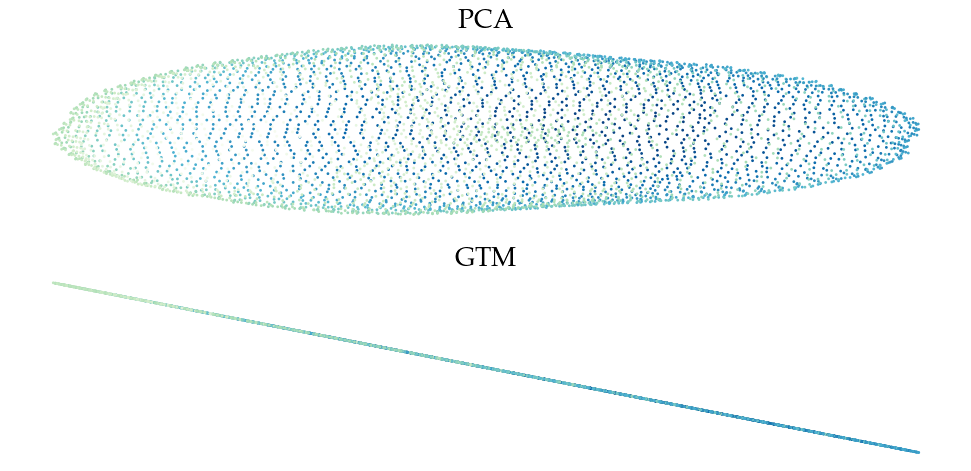

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
for ax in axs.flatten():
    ax.axis('off')
ax1, ax2 = axs.flatten()

field = "z"
cmap = "GnBu"

# ax1.scatter(equirectangular_x, equirectangular_y, c=positions[field], cmap=cmap, s=1)
# ax1.set_title("Equirectangular")

# ax2.scatter(conic_ellipsoid_x, conic_ellipsoid_y, c=positions[field], cmap=cmap, s=1)
# ax2.set_title("Conic Ellipsoid")

# ax3.scatter(conic_x, conic_y, c=positions[field], cmap=cmap, s=1)
# ax3.set_title("Conic")



# ax4.scatter(lambert_azimuthal_x, lambert_azimuthal_y, c=positions[field], cmap=cmap, s=0.1)
# ax4.set_title("Lambert Azimuthal")

# ax5.scatter(van_der_grinten_x, van_der_grinten_y, c=positions[field], cmap=cmap, s=1)
# ax5.set_title("Van der Grinten")

# ax6.scatter(cassini_x, cassini_y, c=positions[field], cmap=cmap, s=1)
# ax6.set_title("Cassini")

# ax7.scatter(cassini_ellipsiod_x, cassini_ellipsiod_y, c=positions[field], cmap=cmap, s=1)
# ax7.set_title("Cassini Ellipsiod")

# ax8.scatter(stereographic_x, stereographic_y, c=positions[field], cmap=cmap, s=1)
# ax8.set_title("Stereographic")

ax1.scatter(pca_x, pca_y, c=positions[field], cmap=cmap, s=1)
ax1.set_title("PCA")

ax2.scatter(gtm_x, gtm_y, c=positions[field], cmap=cmap, s=1)
ax2.set_title("GTM")

fig.tight_layout()
# plt.savefig(f"projections.png", dpi=300)
plt.show()

In [38]:
projections = {"lambert": (lambert_azimuthal_x, lambert_azimuthal_y),
               "equirectangular": (equirectangular_x, equirectangular_y),
               "conic_ellipsoid": (conic_ellipsoid_x, conic_ellipsoid_y),
               "conic": (conic_x, conic_y),
               "stereographic": (stereographic_x, stereographic_y),
               "van_der_grinten": (van_der_grinten_x, van_der_grinten_y),
               "cassini": (cassini_x, cassini_y),
               "cassini_ellipsiod": (cassini_ellipsiod_x, cassini_ellipsiod_y),
               "pca": (pca_x, pca_y),
               "gtm": (gtm_x, gtm_y)}

In [41]:
def sort_by_hilbert(positions, X, Y, multiplier=1_000_000):
    X += abs(min(X))
    Y += abs(min(Y))
    bits = int(np.log2(max(max(X), max(Y)) * multiplier)) + 1
    print(bits)
    hilbertcurve = HilbertCurve(bits, 2)

    x, y = X, Y
    d = hilbertcurve.distances_from_points(list(zip((multiplier*x).astype(int), (multiplier*y).astype(int))))
    # d = positions.apply(lambda x: interleave3(int(multiplier*x.y), int(multiplier*x.x), int(multiplier*x.z)), axis=1)
    if len(set(d)) != len(d):
        print("Duplicates!!")

    return positions.assign(hilbert=d).sort_values("hilbert")

print(positions)
ordered = sort_by_hilbert(positions, van_der_grinten_x, van_der_grinten_y)
print(ordered)
# with open(f"../goserver/neuron_order_level_{level}.txt", "w") as f:
#     f.write(" ".join(ordered["id"].astype(str)))

              x          y         z    id
index                                     
0      1.698874  70.343688  0.601685     0
1      1.904782  70.404715 -1.400644     1
2      3.671188  69.309390  0.804720     2
3      2.295784  69.239066  3.645945     3
4     -0.789082  70.307442  4.335904     4
...         ...        ...       ...   ...
4995  -2.167020 -72.518749 -6.025323  4995
4996   1.786097 -72.547960 -5.553128  4996
4997   2.307604 -71.655299 -1.399803  4997
4998  -0.784268 -71.645010 -0.765602  4998
4999   0.431353 -71.614601 -2.668810  4999

[5000 rows x 4 columns]
29
               x         y          z    id             hilbert
index                                                          
2590  -49.192833 -0.658469 -69.519284  2590    6350076748131193
2713  -50.169091 -5.636070 -69.792343  2713    6381083895968880
2591  -44.948010 -0.646842 -71.028697  2591    6464589109238557
2592  -40.632175 -0.634015 -73.529809  2592    6784604529402906
2715  -41.626841 -5.619663 -7

In [39]:
projection = "pca"

29


  0%|          | 0/50000 [00:00<?, ?it/s]

maxd=-1


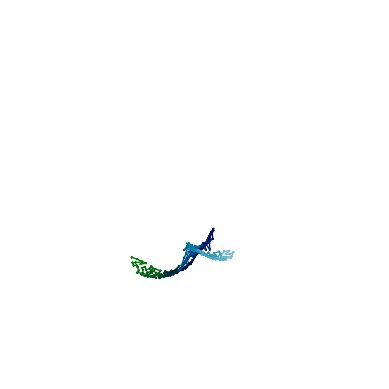

In [20]:
plt.close("all")
fig = plt.figure()
xlim = min(positions.x), max(positions.x)
ylim = min(positions.y), max(positions.y)
zlim = min(positions.z), max(positions.z)
ax = fig.add_subplot(projection="3d", xlim=xlim, ylim=ylim, zlim=zlim)
ax.view_init(elev=15., azim=-90.)
ordered = sort_by_hilbert(positions, *projections[projection])
# ax.scatter(area2.x, area2.y, area2.z, c=area2.index, cmap="rainbow", s=1)

walk = ordered[["x", "y", "z"]].to_numpy()
locations = positions[["x", "y", "z"]].to_numpy()
colors = plt.cm.ocean(np.linspace(0, 1, 3000))

line, = ax.plot([], [], [], lw=1)

j = 0

maxd = -1

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return line,

def animate(i):
    global j, maxd
    if j == len(locations) - 2:
        j += 1
        return line,
    d = 0
    while j != 0 and (d := np.linalg.norm(locations[j] - locations[j - 1])) < 1:
        j += 1
        pbar.update(1)
    maxd = max(maxd, d)
    pbar.update(1)
    j += 1
    ax.view_init(elev=15., azim=360 / frames * i + 60)
    line.set_data(walk[:j, :2].T)
    line.set_3d_properties(walk[:j, 2])
    return line,

plt.axis("off")

try:
    pbar.close()
except NameError:
    pass


frames = len(positions)
pbar = tqdm(total=len(positions))
# anim = animation.FuncAnimation(fig, animate, init_func=init, 
# 							frames=frames, interval=5000 / frames) 

# with open("stereographic_video.html", "w") as f:
#     print(anim.to_html5_video(embed_limit=200), file=f)
# pbar = tqdm(total=frames)
# callback = lambda current_frame, total_frames: pbar.update(1)
# anim.save(f'{projection}_level{level}_video.mp4',writer='ffmpeg') 

for j in range(0, 2500):
    ax.plot(walk[j:j+2, 0], walk[j:j+2, 1], zs=walk[j:j+2, 2], c=colors[j], lw=1)
    

print(f"{maxd=}")
# plt.savefig(f"brain-walk.pdf")
# plt.show()

In [46]:
pca = PCA(n_components=1).fit_transform(positions[["x", "y", "z"]])
pca

array([[-5.22429757],
       [-5.80482082],
       [-3.23112168],
       ...,
       [ 8.73273091],
       [ 6.13209541],
       [ 6.52037458]])

In [48]:
positions.assign(hilbert=pca).sort_values("hilbert")

walk = positions[["x", "y", "z"]].to_numpy()

avgd = 0
maxd = -1
for i in range(1, len(walk)):
    d = np.linalg.norm(walk[i] - walk[i - 1])
    avgd += d
    maxd = max(maxd, d)


In [50]:
maxd

15.108068318591508

In [42]:
for projection in projections:
    maxd = -1
    avgd = 0
    ordered = sort_by_hilbert(positions, *projections[projection])

    walk = ordered[["x", "y", "z"]].to_numpy()

    for i in range(1, len(walk)):
        d = np.linalg.norm(walk[i] - walk[i - 1])
        avgd += d
        maxd = max(maxd, d)

    avgd /= len(walk)
    print(f"{projection} {avgd=:.4f}")
    print(f"{projection} {maxd=:.4f}")


29
lambert avgd=6.0157
lambert maxd=42.7321
28
equirectangular avgd=6.8114
equirectangular maxd=43.0143
30
conic_ellipsoid avgd=4.8997
conic_ellipsoid maxd=135.6984
23
conic avgd=4.7443
conic maxd=60.4237
35
stereographic avgd=5.2526
stereographic maxd=25.9875
29
van_der_grinten avgd=4.5597
van_der_grinten maxd=25.9337
29
cassini avgd=4.5741
cassini maxd=20.8445
31
cassini_ellipsiod avgd=6.0639
cassini_ellipsiod maxd=46.9583
28
pca avgd=49.8090
pca maxd=136.1762


24
0 
maxd=0.23158211988132857
van_der_grinten_maxd=0.23158211988132857


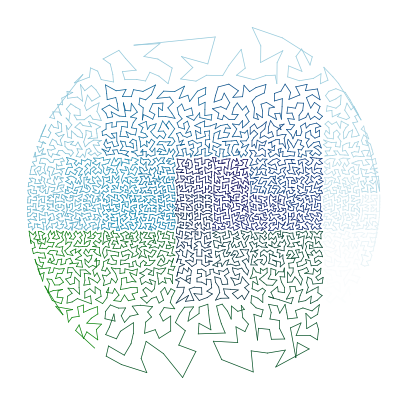

In [23]:
def plot_hilbert_curve(X, Y, name):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # min-max normalization
    X = (X - min(X)) / (max(X) - min(X))
    Y = (Y - min(Y)) / (max(Y) - min(Y))

    multiplier = 10_000_000
    bits = int(np.log2(max(max(X), max(Y)) * multiplier)) + 1
    hilbertcurve = HilbertCurve(bits, 2)
    ordered = sort_by_hilbert(positions, X, Y, multiplier=multiplier)
    # ax.scatter(X, Y, s=1, c="black", alpha=0.2)
    # ax.set_title(f"{name} projection + Hilbert curve")

    colors = plt.cm.ocean(np.linspace(0, 1, len(ordered)))
    maxd = 0
    xs, ys = [], []
    for i, (h1, h2) in enumerate(zip(ordered.hilbert, ordered.hilbert[1:])):
        if i % 5000 == 0:
            print(f"{i} ", end="", flush=True)
        x1, y1 = hilbertcurve.point_from_distance(h1)
        x2, y2 = hilbertcurve.point_from_distance(h2)
        x1, y1 = x1 / multiplier, y1 / multiplier
        x2, y2 = x2 / multiplier, y2 / multiplier
        d = np.linalg.norm(np.array([x1, y1]) - np.array([x2, y2]))
        maxd = max(maxd, d)
        xs.append(x1)
        ys.append(y1)
        ax.plot([x1, x2], [y1, y2], c=colors[i], lw=0.5)
    # ax.plot(xs, ys, c="red", lw=0.5)
    ax.axis("off")
    print()
    print(f"{maxd=}")
    plt.savefig(f"{name}_hilbert_curve.pdf")
    # plt.show()
    return maxd

van_der_grinten_maxd = plot_hilbert_curve(van_der_grinten_x, van_der_grinten_y, "Van der Grinten")
# conic_maxd = plot_hilbert_curve(conic_x, conic_y, "Conic")
# conic_ellipsoid_maxd = plot_hilbert_curve(conic_ellipsoid_x, conic_ellipsoid_y, "Conic (ellipsoid)")
# equirectangular_maxd = plot_hilbert_curve(equirectangular_x, equirectangular_y, "Equirectangular")
# cassini_maxd = plot_hilbert_curve(cassini_x, cassini_y, "Cassini")

print(f"{van_der_grinten_maxd=}")
# print(f"{conic_maxd=}")
# print(f"{conic_ellipsoid_maxd=}")
# print(f"{equirectangular_maxd=}")
# print(f"{cassini_maxd=}")


100%|██████████| 63/63 [00:00<00:00, 683.68it/s]


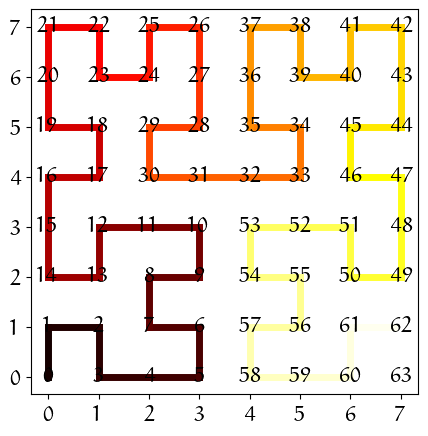

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
N = 2**3
xs = []
ys = []
hilbertcurve = HilbertCurve(np.log2(N), 2)

# (2**n)**2 = 2**(2n)

colors = plt.cm.hot(np.linspace(0, 1, N**2))
fontsize = 14
for i in tqdm(range(1, N**2)):
    x1, y1 = hilbertcurve.point_from_distance(i - 1)
    x2, y2 = hilbertcurve.point_from_distance(i)
    # xs.append(x2)
    # ys.append(y2)
    ax.plot([x1, x2], [y1, y2], c=colors[i], lw=5, alpha=0.6)
    ax.text(x1, y1, f"${i - 1}$", ha='center', va='center')
ax.text(x2, y2, f"${N**2 - 1}$", ha='center', va='center')
# ax.plot(xs, ys, c="black", alpha=0.2)
# ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_yticks(list(range(0, N)))
ax.set_xticks(list(range(0, N)))
# ax.set_xticks([])
# plt.show()
plt.savefig("hilbert_curve.pdf", bbox_inches="tight")

In [30]:
hilbertcurve.distances_from_points([(50, 50), (51, 50)])

[2568, 2571]

6.0


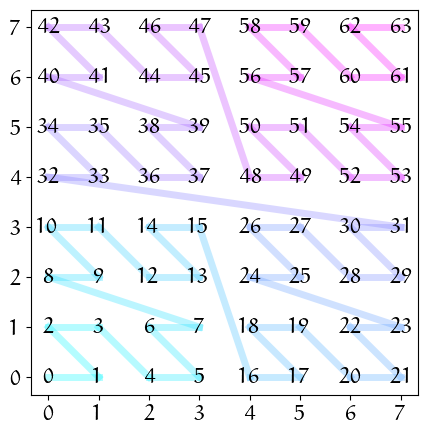

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
N = 2**6
xs = np.zeros(N)
ys = np.zeros(N)

colors = plt.cm.cool(np.linspace(0, 1, N))
fontsize = 14
for i in range(1, N):
    x1, y1 = deinterleave2(i - 1)
    x2, y2 = deinterleave2(i)

    ax.plot([x1, x2], [y1, y2], c=colors[i], lw=5, alpha=0.3)
    ax.text(x1, y1, f"${i - 1}$", ha='center', va='center')
ax.text(x2, y2, f"${N - 1}$", ha='center', va='center')
print(np.log2(N))
ax.set_yticks(list(range(int(np.log2(N)) + 2)))
ax.set_xticks(list(range(int(np.log2(N)) + 2)))
# ax.set_xticks([])
# plt.show()
plt.savefig("z_curve.pdf", bbox_inches="tight")